<a href="https://colab.research.google.com/github/bhenderson11/Pokemon_2-/blob/main/Pokemon_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [ ]:

# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/lantian773030/pokemonclassification') # insert ypu kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bethjane398
Your Kaggle Key: ··········


100%|██████████| 417M/417M [00:04<00:00, 94.7MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.Pad(padding=(1, 1, 1, 1), fill=0)



])


In [ ]:
dataset = datasets.ImageFolder("/content/pokemonclassification/PokemonData", transform = transform)



train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

train_size = int(train_ratio * len(dataset))
val_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Original dataset has {len(dataset)} samples')
print(f'Train set has {len(train_dataset)} samples')
print(f'Validation set has {len(val_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original dataset has 6820 samples
Train set has 5456 samples
Validation set has 682 samples
Test set has 682 samples


In [ ]:
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = True)
valid_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


In [ ]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

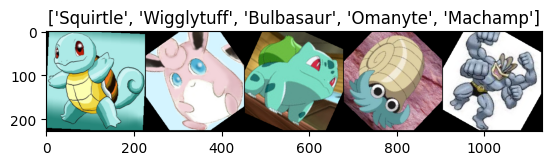

In [ ]:
def imshow(inp, titles=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if titles is not None:
        plt.title(titles)
    plt.pause(0.001)

train_loader_for_vis = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))
out = torchvision.utils.make_grid(inputs)


# Create titles for the images based on the class indices
titles = [class_names[x] for x in classes]

# Display the batch of images
imshow(out, titles)





In [ ]:
print(classes)

tensor([128, 147,  10,  93,  71])


In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    self.cnn_layers= nn.Sequential(
        nn.Conv2d(3, 64, 1, 1),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.MaxPool2d(2,2,0),

        nn.Conv2d(64, 128, 3, 1, 1 ),
        nn.ReLU(),
        nn.MaxPool2d(2,2,0),

        nn.Conv2d(128, 256, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(4,4,0),

    )

    self.fc_layers = nn.Sequential(
        nn.Linear(256*14*14, 256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,150)

    )

  def train_dataloader(self):
        return self.train_dataset

  def test_dataloader(self):
        return self.test_dataset

  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.flatten(1)
    x = self.fc_layers(x)
    return x



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyCNN()
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [ ]:
# The number of training epochs.
n_epochs = 10

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 001/010] Train: loss=4.81171, acc=0.01451 | Valid: loss=4.48898, acc=0.04167


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 002/010] Train: loss=4.12510, acc=0.06487 | Valid: loss=4.06124, acc=0.08750


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 003/010] Train: loss=3.55944, acc=0.13777 | Valid: loss=3.61450, acc=0.18194


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 004/010] Train: loss=2.99168, acc=0.23641 | Valid: loss=3.15864, acc=0.24583


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 005/010] Train: loss=2.55943, acc=0.32573 | Valid: loss=2.83565, acc=0.30972


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 006/010] Train: loss=2.30934, acc=0.38002 | Valid: loss=2.72846, acc=0.32083


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 007/010] Train: loss=2.07696, acc=0.43513 | Valid: loss=2.58912, acc=0.35000


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 008/010] Train: loss=1.89089, acc=0.47911 | Valid: loss=2.56382, acc=0.36389


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 009/010] Train: loss=1.73898, acc=0.51077 | Valid: loss=2.42684, acc=0.37917


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch: 010/010] Train: loss=1.63898, acc=0.53650 | Valid: loss=2.30898, acc=0.41111


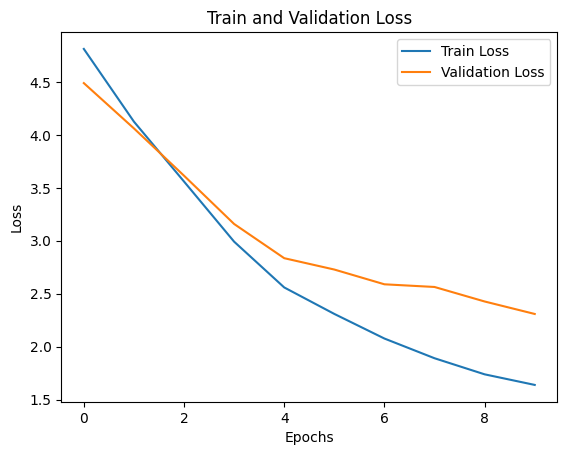

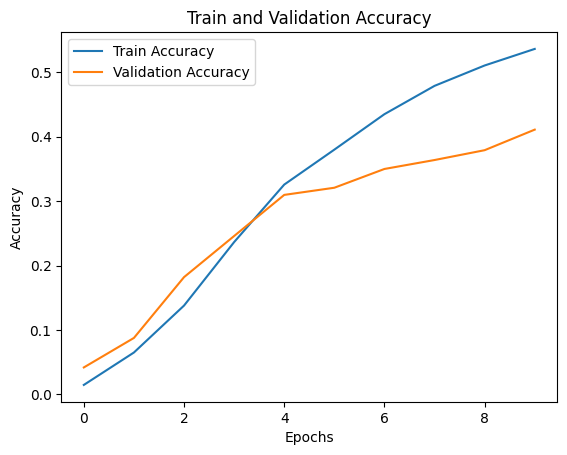

In [ ]:
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

# Initialize variables to store counts for each class
class_correct = torch.zeros(len(class_names), device=device)
class_total = torch.zeros(len(class_names), device=device)

with torch.no_grad():  # Disable gradient calculation for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs to the same device as model
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).squeeze()

        # Update counts for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Calculate accuracy for each class
class_accuracy = class_correct / class_total

# Print accuracy for each class
for i, class_name in enumerate(class_names):
    print(f'Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%')




Accuracy for Abra: 100.00%
Accuracy for Aerodactyl: 0.00%
Accuracy for Alakazam: 50.00%
Accuracy for Alolan Sandslash: 33.33%
Accuracy for Arbok: 50.00%
Accuracy for Arcanine: 50.00%
Accuracy for Articuno: 25.00%
Accuracy for Beedrill: 100.00%
Accuracy for Bellsprout: 50.00%
Accuracy for Blastoise: 28.57%
Accuracy for Bulbasaur: 100.00%
Accuracy for Butterfree: 50.00%
Accuracy for Caterpie: 100.00%
Accuracy for Chansey: 25.00%
Accuracy for Charizard: 14.29%
Accuracy for Charmander: 25.00%
Accuracy for Charmeleon: 80.00%
Accuracy for Clefable: 100.00%
Accuracy for Clefairy: 0.00%
Accuracy for Cloyster: 20.00%
Accuracy for Cubone: 40.00%
Accuracy for Dewgong: 0.00%
Accuracy for Diglett: 0.00%
Accuracy for Ditto: 75.00%
Accuracy for Dodrio: 0.00%
Accuracy for Doduo: 33.33%
Accuracy for Dragonair: 75.00%
Accuracy for Dragonite: 16.67%
Accuracy for Dratini: 0.00%
Accuracy for Drowzee: 75.00%
Accuracy for Dugtrio: 60.00%
Accuracy for Eevee: 25.00%
Accuracy for Ekans: 100.00%
Accuracy for Ele

# First attempt

 **On my first attempt values are** : Train: loss=0.46548, acc=0.85502 | Valid: loss=2.13160, acc=0.53056 after 10 epochs with a batch size of 40. transformations: transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

  model is overfitting.

  Ways to tackle overfitting:
  -More data- but this would be very time consuming as I would need to find the images and label them all myself.
  - Data Augmentation- I have already done some data augmentation
  - Weights are too high - so add a dropout layer. I will start with one dropout layer

# Second attempt
**Second attempt (one dropout layer added)**
  [Epoch: 010/010] Train: loss=0.88038, acc=0.73832 | Valid: loss=1.84541, acc=0.53194



  Marginal improvement to validation accuracy

  # Third attempt

  **Third attempt- second dropout layer and rotation changed to 45 degrees **

  [Epoch: 010/010] Train: loss=1.43603, acc=0.57801 | Valid: loss=2.28357, acc=0.41667

  much worse now!
  I will delete the second dropout layer and increase the first dropout layer from 0.3 to 0.5

  # Fourth attempt

  [Epoch: 010/010] Train: loss=1.35713, acc=0.60055 | Valid: loss=2.21449, acc=0.43333
oh dear! slightly better. I am going to remove one of the transformations (horizontal flips)